In [3]:
# Inputs
load = [100, 700] # load
capacity = [1, 500] # capacity
latency = [10, 80] # latency
availability = [0, 1] # availability

# Problem Definitions
load_problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newLoad'],
    'bounds': [ load, capacity, latency, availability, load],
    'simulation':{
        'scenario':'load',
        'models':["A", "B", "C", "D"],
        'independent':'loadFromX',
        'dependent':['loadFromY', 'meanLatencyFromY']
    }
}
latency_problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newLatency'],
    'bounds': [ load, capacity, latency, availability, latency],
    'simulation':{
        'scenario':'latency',
        'models':["A", "E", "F", "G"],
        'independent':'meanLatencyFromZ',
        'dependent':['meanLatencyFromY', 'meanAvailabilityFromY']
    }
}
availability_problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newAvailability'],
    'bounds': [ load, capacity, latency, availability, availability],
    'simulation':{
        'scenario':'availability',
        'models':["A", "H", "F", "I", "J"], # Model J Broken
        'independent':'meanAvailabilityFromZ',
        'dependent':['meanAvailabilityFromY', 'loadFromY']
    }
}
capacity_problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newCapacity'],
    'bounds': [ load, capacity, latency, availability, capacity],
    'simulation':{
        'scenario':'capacity',
        'models':["A", "K", "L"],
        'independent':'zCapacity',
        'dependent':['poolSize']
    }
}
debug_problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newAvailability'],
    'bounds': [ load, capacity, latency, availability, availability],
    'simulation':{
        'scenario':'availability',
        'models':["J"],
        'independent':'meanAvailabilityFromZ',
        'dependent':['meanAvailabilityFromY', 'loadFromY']
    }
}


In [4]:
from SALib.sample import saltelli
import numpy as np
from os import path
import json

# Model Inputs
#problem = availability_problem
problem = load_problem

# Suggesting N = 1000
param_values = saltelli.sample(problem, 100)

sensitivity_path = path.join("..", "out", "sensitivity")
simulation_file_path = path.join(sensitivity_path, "simulation.json")
param_file_path = path.join(sensitivity_path, "param_values.txt")

print("saving")
print("\t", simulation_file_path)
print("\t", param_file_path)

np.savetxt(param_file_path, param_values, fmt='%1.4f')
with open(simulation_file_path, 'w', encoding="utf-8") as f:
  json.dump(problem["simulation"], f, ensure_ascii=False, indent=4)

saving
	 ..\out\sensitivity\simulation.json
	 ..\out\sensitivity\param_values.txt


C:\Users\matt\AppData\Local\Programs\Python\Python39\lib\site-packages\SALib\sample\saltelli.py:80: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


## Questions To Ask
- Do we want to have this model accept some combination of degradations at the same time or just one?
    > Limit it to just one degradation at a time
- Some scenarios have different architecture? Z has unlimited capacity in most scenarios.
    > I think we need 1 "model" per architecture. Also means, we may need to consider different input distributions per scenario, since they would each be a situation (i.e. we care about latency in this one, so our latency distribution is wider, etc)
- `TICK_DILATION` and output values? How does this affect our sensitivity if we report latency as actual latency scaled by the dilation value?
    > I think we need to care about magnitude here, since the Y axis for sensitivity is this magnitude value.
- We need to remove any random sampling from our models. They need to be deterministic
    > Might be able to get away without determinisim in this case (otherwise, why do they run the models several times with same input)
- We might need to cast inputs to integers (at least some of them)
- We might need to not to do that nan to 0 thing at the end. This migtht mess up some M/S outputs

## Run
```
npx ts-node src/sensitivity/index.ts
```

In [10]:
# Outputs from Time Series
""" Some assistance from this article
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
"""

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def time_series_crosscorr(d1, d2, window):
    """
    Returns crosscorr, delay
    """
    #rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]
    rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]

    # Early exit if no window
    if window == 0:
        #print(window, 0, rs)
        return rs[0], 0
    
    maxCrossCorr = np.amax(rs)
    maxCrossCorrIndex = np.argmax(rs)
    minCrossCorr = np.amin(rs)
    minCrossCorrIndex = np.argmin(rs)

    actualCrossCorr = 0
    actualCrossCorrIndex = 0

    if maxCrossCorr > -1 * minCrossCorr:
        actualCrossCorr = maxCrossCorr
        actualCrossCorrIndex = maxCrossCorrIndex
    else:
        actualCrossCorr = minCrossCorr
        actualCrossCorrIndex = minCrossCorrIndex

    offset = -window + actualCrossCorrIndex
    #print(window, actualCrossCorrIndex, rs)

    return actualCrossCorr, offset

def ending_n_mean(datay, n):
    return np.mean(datay[-n:])

def ending_n_slope(datay, n):
    return (datay.iloc[-1] - datay.iloc[-n]) / n

def start_end_mean_diff(datay, n):
    return (datay.iloc[n] - datay.iloc[0]) / n - ending_n_slope(datay, n)

def mean_n(datay, n, k):
    start = n * k
    end = start + n
    
    if len(datay) < start:
        return np.nan
    if(len(datay) < end):
        return np.nan

    return np.mean(datay[start:end])

def slope_n(datay, n, k):
    start = n * k
    end = start + n
    
    if len(datay) <= start:
        return np.nan
    if(len(datay) <= end):
        return np.nan

    return (datay.iloc[end] - datay.iloc[start]) / n








metrics = [
        "CrossCorr",
        "TimeSeriesCrossCorr",
        "TimeSeriesCrossCorrOffset",
        "EndingNMean",
        "EndingNSlope",
        "StartEndMeanDiff",
        "M0", "M1", "M2", "M3", "M4", "M5",
        "S0", "S1", "S2", "S3", "S4", "S5"
    ]

def get_dependent_name_from_output_index(dependents, output_index):
    index = output_index // len(metrics)
    return dependents[index]

def get_output_name(index):
    """
    Gets the corresponding metric name based on the index of the output
    """
    return metrics[index % len(metrics)]

def get_dependent_output(a, b):
    """
    a: independent series
    b: dependent series
    """
    ending_n = 15

    c_a_b = crosscorr(a, b)
    tc_a_b, offset_a_b = time_series_crosscorr(a, b, 6)
    em_a_b = ending_n_mean(b, ending_n)
    es_a_b = ending_n_slope(b, ending_n)
    sed_a_b = start_end_mean_diff(b, ending_n)

    # selected to be 16, since that is when the degradation starts (8 seconds in, 16 measurements)
    slice_size = 16
    m0 = mean_n(b, slice_size, 0)
    m1 = mean_n(b, slice_size, 1)
    m2 = mean_n(b, slice_size, 2)
    m3 = mean_n(b, slice_size, 3)
    m4 = mean_n(b, slice_size, 4)
    m5 = mean_n(b, slice_size, 5)

    s0 = slope_n(b, slice_size, 0)
    s1 = slope_n(b, slice_size, 1)
    s2 = slope_n(b, slice_size, 2)
    s3 = slope_n(b, slice_size, 3)
    s4 = slope_n(b, slice_size, 4)
    s5 = slope_n(b, slice_size, 5)

    return [
        c_a_b, tc_a_b, offset_a_b, em_a_b, es_a_b, sed_a_b, 
        m0, m1, m2, m3, m4, m5, s0, s1, s2, s3, s4, s5
    ]


def get_output(series, independent, dependents, index):
    independent_series = series[independent]

    result = []
    for d in dependents:
        dependent_series = series[d]
        result += get_dependent_output(independent_series, dependent_series)
    
    return result

In [5]:
# Which simulation results to use, hardcoded because of the disconnect needing to run NodeJS in the previous simulation step
time_series_path = path.join("..", "out", "sensitivity", "results-availability-1627519470324")

with open(path.join(time_series_path, "simulation.json")) as json_file:
    output_simulation_data = json.load(json_file)

independent = output_simulation_data["independent"]
dependents = output_simulation_data["dependent"]

In [4]:
import glob
import pandas as pd
import re


for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output = path.join(time_series_path, model)
    time_series_file_name_pattern = path.join(time_series_model_output, "*.csv")
    all_time_series_csv_files = glob.glob(time_series_file_name_pattern)
    print("\tFound", len(all_time_series_csv_files), "files")

    counter = 0

    # sort by the id so each row still matches the id of the time series
    sorted_time_series_files = sorted(all_time_series_csv_files, key=lambda x:float(re.findall("(\d+)\-.*\.csv",x)[0]))
    time_series = [pd.read_csv(f) for f in sorted_time_series_files]
    outputs = [get_output(s, independent, dependents, index) for index, s in enumerate(time_series)]

    # transpose so we can just write each column as a file with normal array access
    transposed = np.transpose(outputs)

    # for debugging, print individually
    #for index, o in enumerate(transposed):
    #    file_name = path.join(time_series_model_output, f"output_{index}_values.txt")
    #    np.savetxt(file_name, o, fmt='%1.8f')

    all_output_file_name = path.join(time_series_model_output, "output_all_values.txt")
    np.savetxt(all_output_file_name, outputs, fmt='%1.8f')



Model: A
	Found 1200 files
Model: H
	Found 1200 files
Model: F
	Found 1200 files
Model: I
	Found 1200 files


In [5]:
from SALib.analyze import sobol
import matplotlib.pyplot as plot
from SALib.plotting.bar import plot as barplot


# to print Numpy Arrays
def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

print("Assuming independent", independent, "and dependents", dependents)

for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")

    # tranpose to get {number of output} columns of {number of simulations} rows
    outputs = np.transpose(np.loadtxt(all_output_file_name, float))
    
    #all_output_files_pattern = path.join(time_series_model_output_path, "output_*_values.txt")
    #all_output_files = glob.glob(all_output_files_pattern)
    #print("\tFound", len(all_output_files), "files") # , "files that matched", all_output_files_pattern)

    # sort by the id so each row still matches the id of the time series
    #sorted_output_files = sorted(all_output_files, key=lambda x:float(re.findall("(\d+)\_.*\.txt",x)[0]))

    #outputs = [np.loadtxt(f, float) for f in sorted_output_files]
    #print(outputs)


    converted = [np.nan_to_num(o) for o in outputs]
    analysis = [sobol.analyze(problem, o) for o in converted]

    # save in JSON the FULL FILE including invalid NaN values for historical reasoning
    analysis_output_file_name = path.join(time_series_model_output_path, "analysis.json")
    with open(analysis_output_file_name, 'w', encoding="utf-8") as f:
        json.dump(analysis, f, ensure_ascii=False, indent=4, default=default)

    # save only the Total Sensitivity in a csv
    total_sensitivities = dict()
    for d in dependents:
        total_sensitivities[d] = dict()

    for index, a in enumerate(analysis):
        dependent_name = get_dependent_name_from_output_index(dependents, index)
        output_name = get_output_name(index)
        total_sensitivities[dependent_name][output_name] = a["ST"]

    sensitivity_output_file_name = path.join(time_series_model_output_path, "sensitivity.json")
    with open(sensitivity_output_file_name, 'w', encoding="utf-8") as f:
        json.dump(total_sensitivities, f, ensure_ascii=False, indent=4, default=default)
    #print("TOTAL_SENSITIVITIES")
    #print(total_sensitivities)

    # give the labels some more room
    # plot.gcf().subplots_adjust(bottom=0.15)

    # print some quick graphs
    for index, a in enumerate(analysis):
        dependent_name = get_dependent_name_from_output_index(dependents, index)
        output_name = get_output_name(index)

        #analysis_output_path = path.join(time_series_model_output_path, )
        #with open(simulation_file_path, 'w', encoding="utf-8") as f:
        #    json.dump(problem["simulation"], f, ensure_ascii=False, indent=4)

        # Manually draw box plots
        df = a.to_df()
        fig, axes = plot.subplots(1, len(df))
        fig.set_tight_layout(True)

        fig.suptitle(f"Sensitivity of {output_name}({index})")
        for idx, f in enumerate(df):
            axes[idx] = barplot(f, ax=axes[idx])

        img_path = path.join(time_series_model_output_path, f"sen-{index}-{dependent_name}-{output_name}.png")
        plot.savefig(img_path)
        plot.close(fig)
    



#Y = np.loadtxt(time_series_path + "\output_values.txt", float)
#Y = np.nan_to_num(Y)
#Si = sobol.analyze(problem, Y)
#print(Si)
#print(Si['S1'])
#print(Si['ST'])
#Si.plot()

Assuming independent meanAvailabilityFromZ and dependents ['meanAvailabilityFromY', 'loadFromY']
Model: A
Model: H
Model: F
Model: I


# Scatterplot Matrix

Model: A
(1200, 36)
36 18


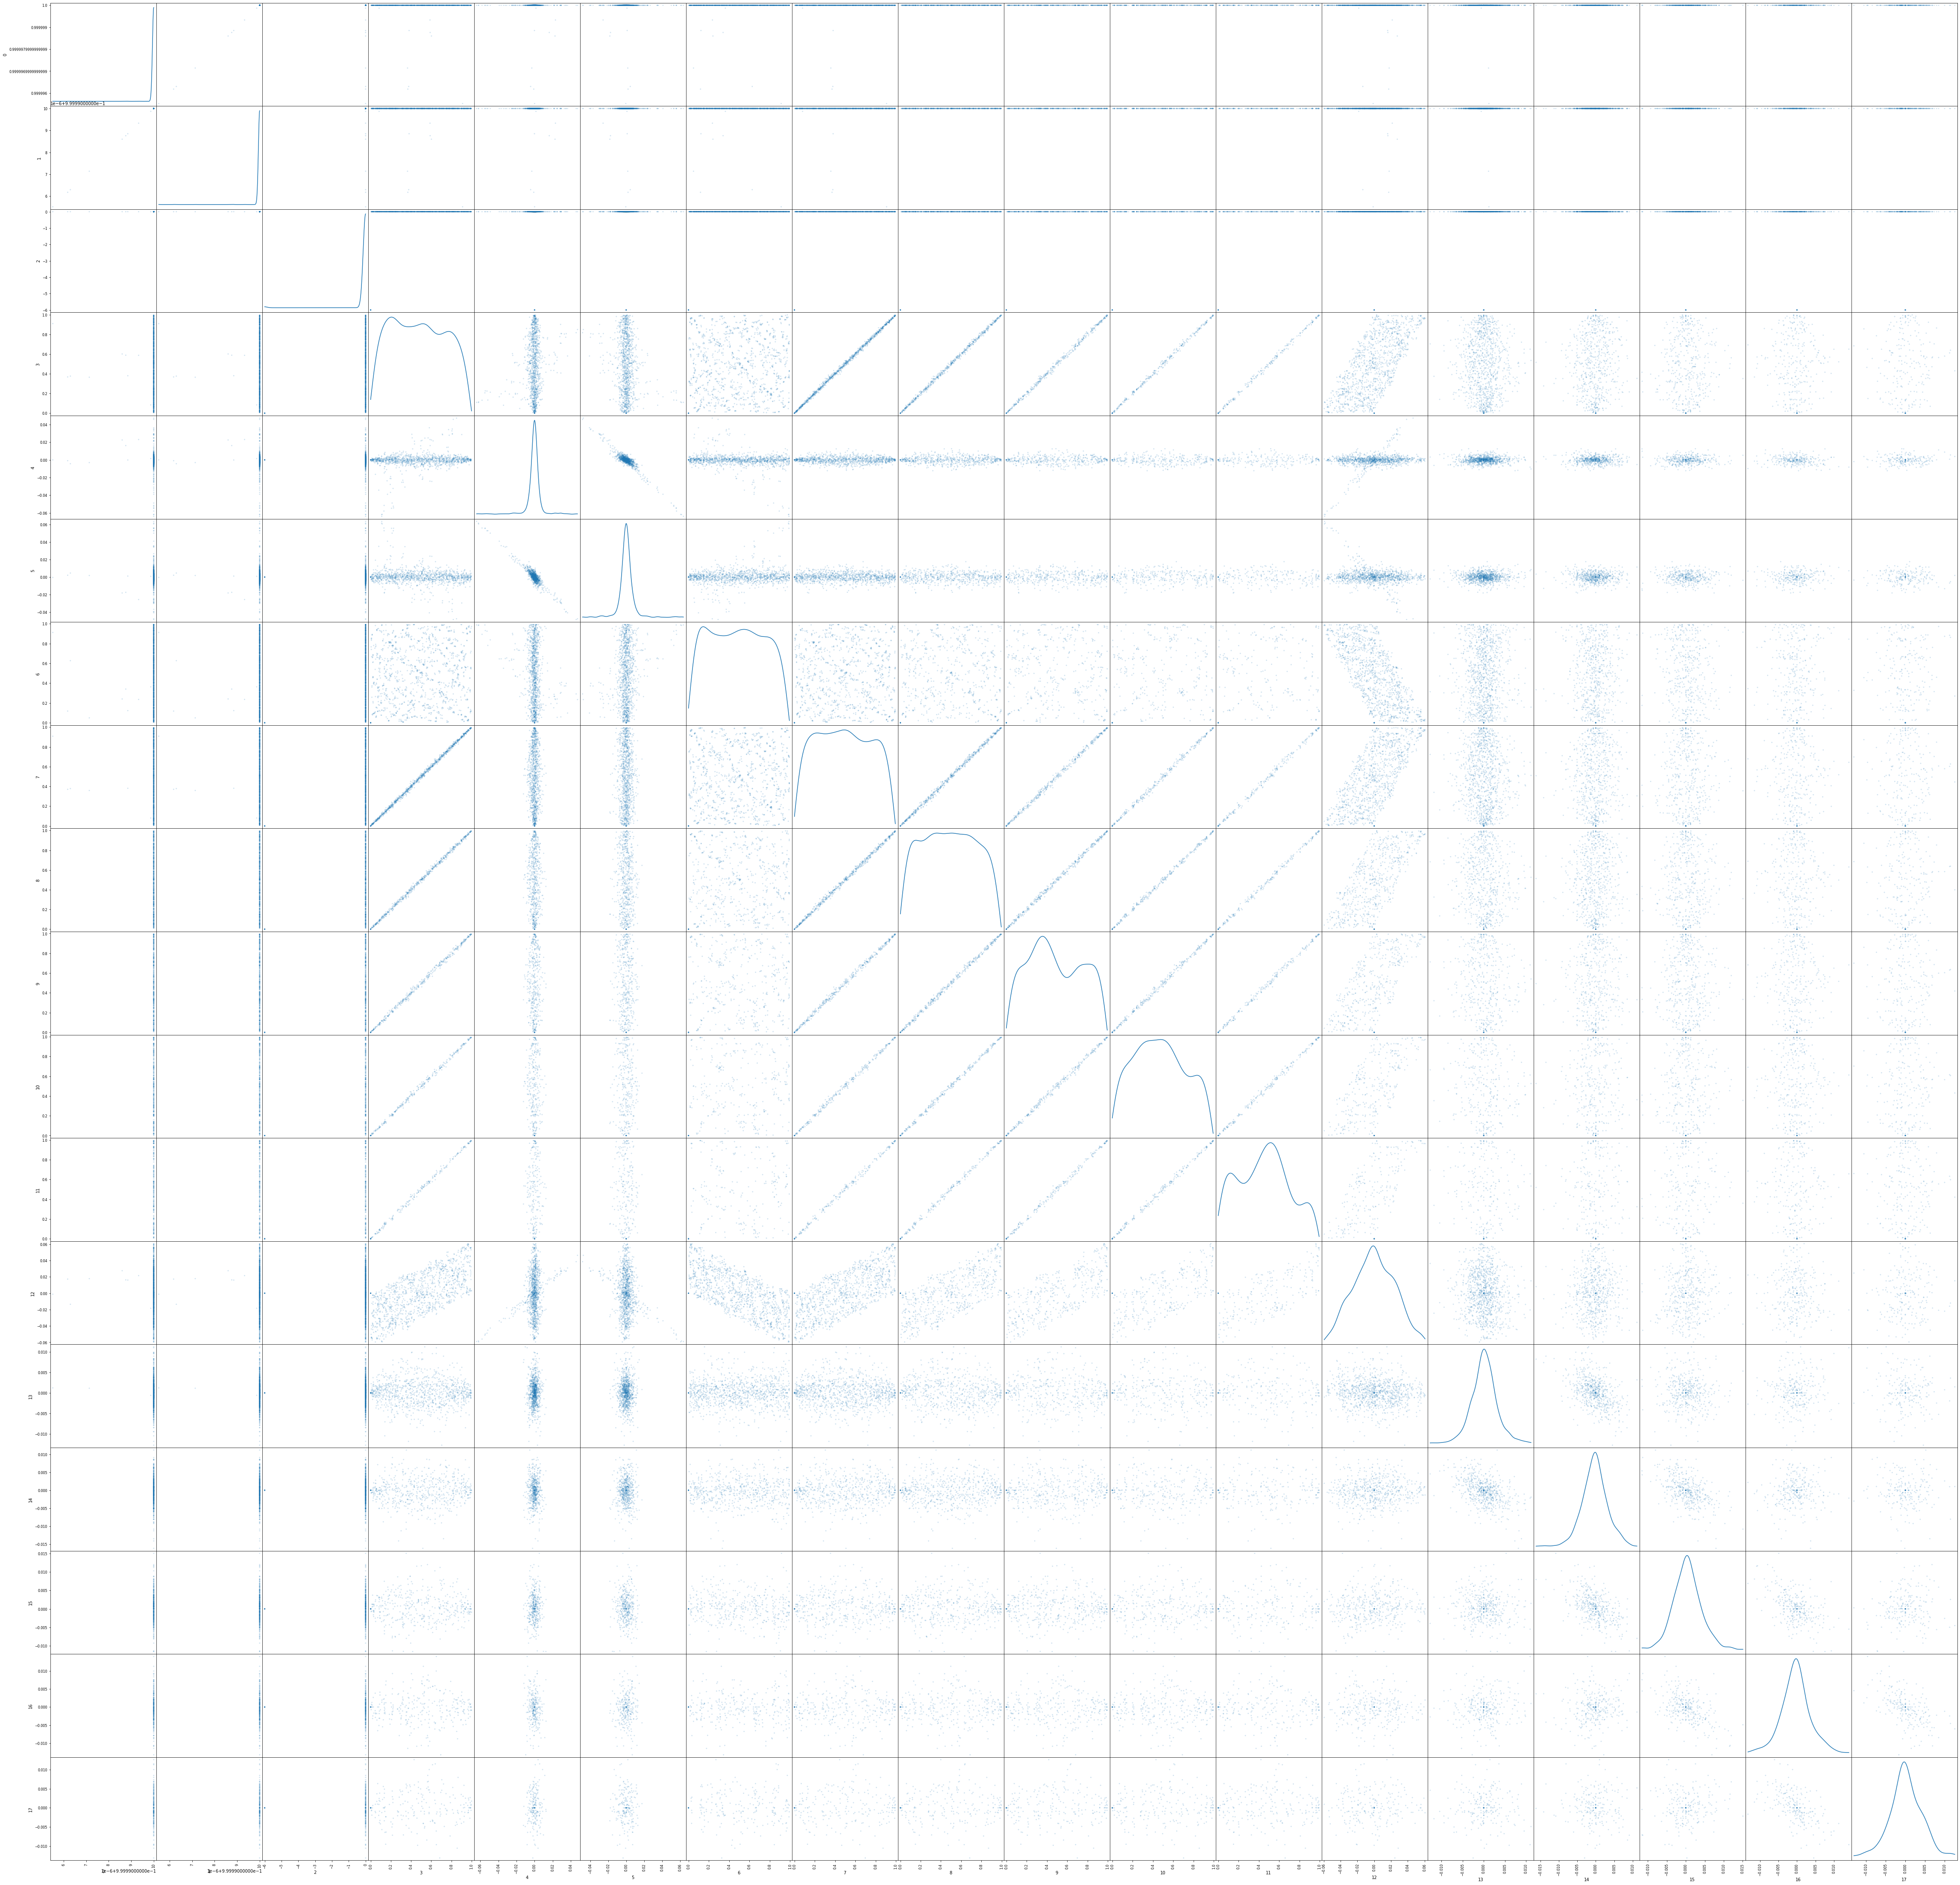

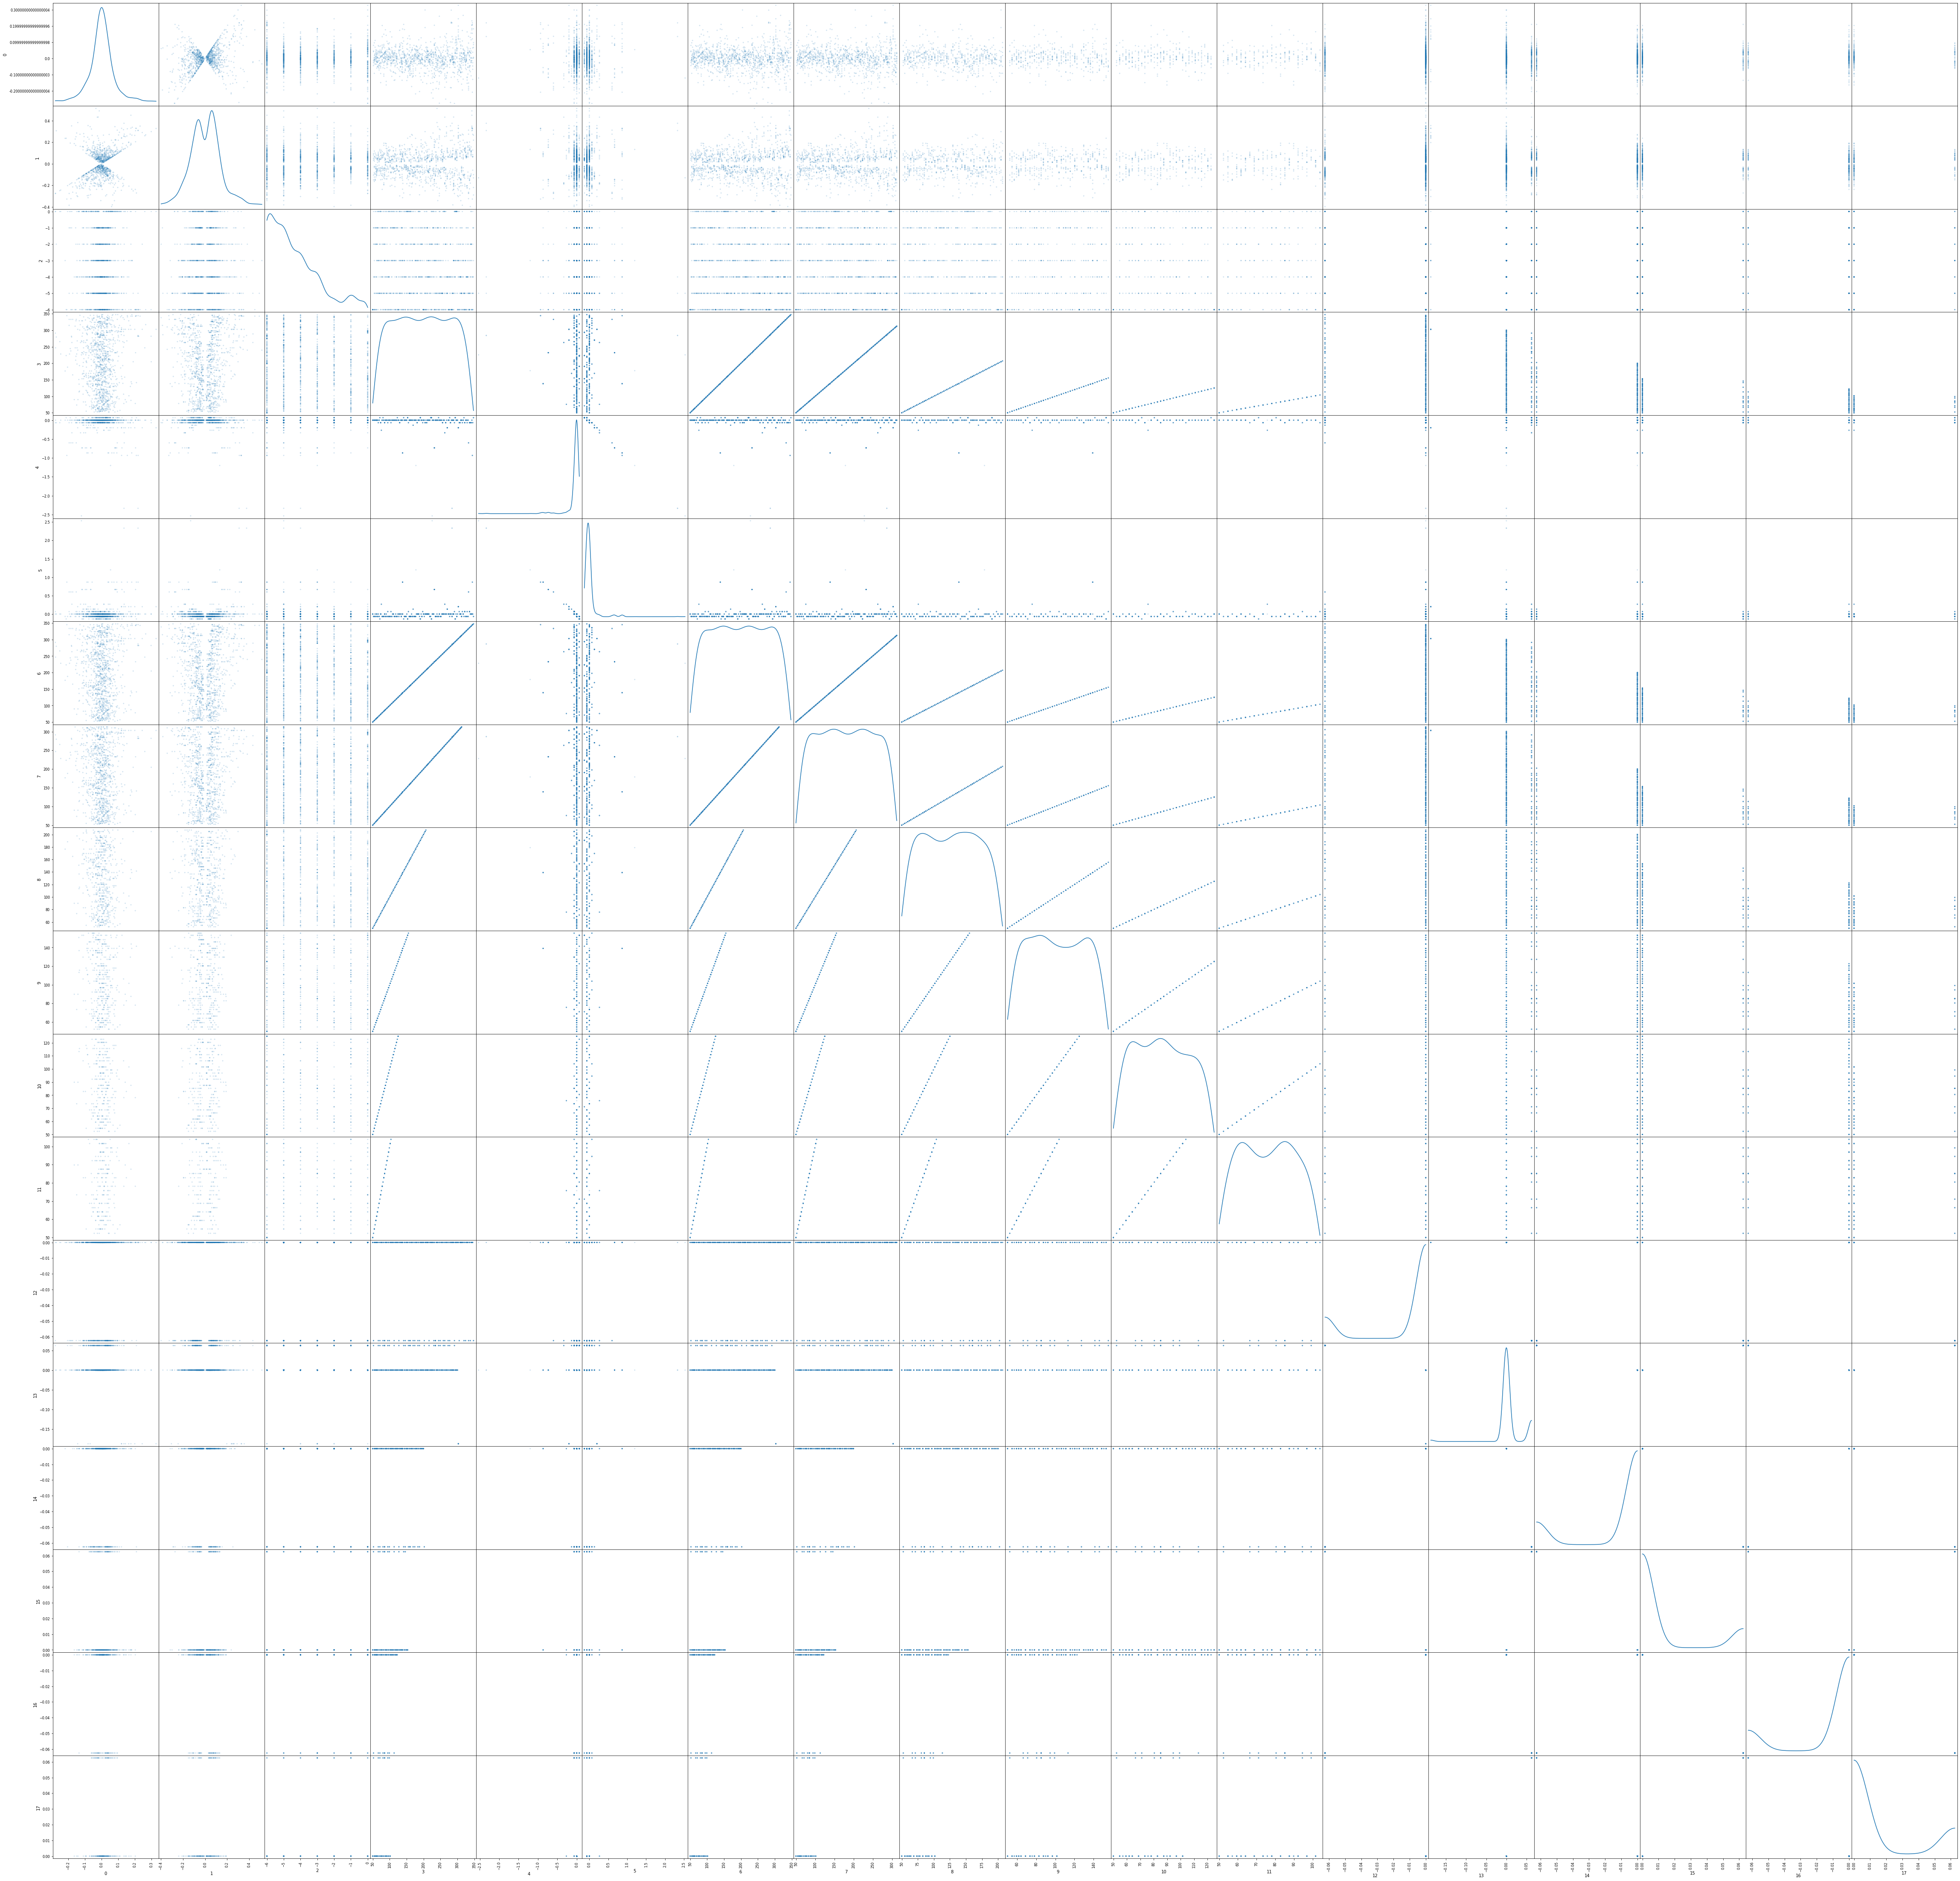

In [18]:
import pandas as pd
import matplotlib.pyplot as plot
from pandas.plotting import scatter_matrix

for model in output_simulation_data["models"]:
    print("Model:", model)
    time_series_model_output_path = path.join(time_series_path, model)
    all_output_file_name = path.join(time_series_model_output_path, "output_all_values.txt")


    # tranpose to get {number of output} columns of {number of simulations} rows
    outputs = np.loadtxt(all_output_file_name, float)

    print(np.shape(outputs))

    num_columns = np.shape(outputs)[1]
    num_outputs = len(metrics)
    print(num_columns, num_outputs)
    for x in range(0, num_columns, num_outputs):
        df = pd.DataFrame(outputs[:, x:x+num_outputs], columns=metrics)
        scatter = scatter_matrix(df, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')

    #df = pd.DataFrame(outputs)
    #scatter = scatter_matrix(df, alpha = 0.2, figsize = (80, 80), diagonal = 'kde')
    #scatter_file = path.join(time_series_model_output_path, "scatter.png")
    #plot.savefig(scatter_file)
    #print("\tsaved image to ", scatter_file)
    break